# Proyecto Final Statistical Learning I: Parte 1

El proyecto consiste en hacer clasificación binaria para determinar si una persona sobrevive(y=1) o no (y=0) del hundimiento del Titanic. Se busca crear un modelo con un nivel de exactitud de al menos el 80%. 

### Objetivo

Crear un modelo combinado por moda de resultados de 4 modelos: Decision Tree, Naive Bayes, SVM y Regresión logística para determinar si una persona sobrevivie o no en el hundimiento del Titanic con una exactitud mínima del 80%.

Importar librerías

In [1041]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import sklearn as sk
from sklearn import tree
from sklearn import svm
from sklearn.impute import SimpleImputer
from sklearn import metrics
from scipy import stats
from math import sqrt
from math import pi
from math import exp
import sklearn.model_selection as model_selection
import seaborn as sns
import time
if tf.__version__.startswith("2."):
    import tensorflow.compat.v1 as tf
    tf.compat.v1.disable_v2_behavior()
    tf.compat.v1.disable_eager_execution()
    print("Enabled compatitility to tf1.x")

Enabled compatitility to tf1.x


### Carga de datos

In [319]:
data = pd.read_csv("data_titanic_proyecto.csv") 
data.head()

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
0,1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Lower,M,N
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Upper,F,Y
2,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Lower,F,Y
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Upper,F,Y
4,5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Lower,M,N


Buscamos el significado de cada columna. Cada campo se refiere a:

* PassengerId - Id del pasajero
* Name - Nombre
* passenger_sex - Sexo de los pasajeros (M/F)
* Age - Edad
* Sibsp - Número de hermanos/esposos abordo 
* Parch - Número de padres/hijos abordo
* Ticket - Número de boleto
* Fare - Tarifa
* Cabin - Camarote
* Embarked - Puerto de embarcación (C = Cherbourg; Q = Queenstown; S = Southampton)
* passenger_class (Lower/Middle/Upper)
* passenger_survived - el pasajero sobrevivió (Y/N)

### Selección y transformación de features

Primero revisamos la estructura general de los datos con info() y describe():

In [320]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PassengerId         891 non-null    int64  
 1   Name                891 non-null    object 
 2   Age                 714 non-null    float64
 3   SibSp               891 non-null    int64  
 4   Parch               891 non-null    int64  
 5   Ticket              891 non-null    object 
 6   Fare                891 non-null    float64
 7   Cabin               204 non-null    object 
 8   Embarked            889 non-null    object 
 9   passenger_class     891 non-null    object 
 10  passenger_sex       891 non-null    object 
 11  passenger_survived  891 non-null    object 
dtypes: float64(2), int64(3), object(7)
memory usage: 83.7+ KB


In [321]:
data.describe()

,PassengerId,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,29.699118,0.523008,0.381594,32.204208
std,257.353842,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,38.000000,1.000000,0.000000,31.000000
max,891.000000,80.000000,8.000000,6.000000,512.329200


In [322]:
data.isnull().sum()

PassengerId             0
Name                    0
Age                   177
SibSp                   0
Parch                   0
Ticket                  0
Fare                    0
Cabin                 687
Embarked                2
passenger_class         0
passenger_sex           0
passenger_survived      0
dtype: int64

Observamos que Age, Cabin y Embarked tienen valores nulos. Para el caso de Cabin (el 77% de los datos tienen valores nulos) y en el caso de Age el 19% son nulos). Para el caso de Age y Embarked podemos hacer imputación de datos. 

Primero graficamos un histograma de la distribución de Age para compararlo con los datos imputados.

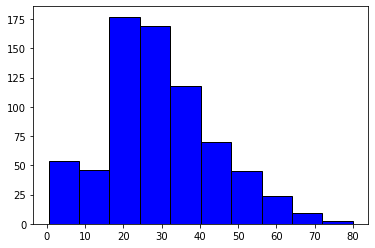

In [323]:
plt.hist(data['Age'], color = 'blue', edgecolor = 'black')
plt.show()

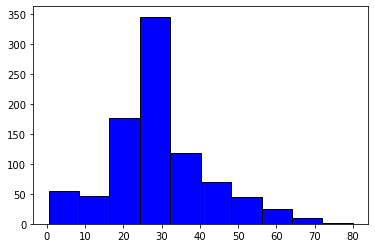

In [324]:
#dataset.fillna(dataset.mean(), inplace=True)

data['Age'].fillna(data['Age'].median(), inplace=True)
plt.hist(data['Age'], color = 'blue', edgecolor = 'black')
plt.show()

Para el caso de 'Embarked' podemos imputar la moda que sería 'S'

In [325]:
data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [326]:
data['Embarked'].fillna('S', inplace=True)
data['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [327]:
data.isnull().sum()

PassengerId             0
Name                    0
Age                     0
SibSp                   0
Parch                   0
Ticket                  0
Fare                    0
Cabin                 687
Embarked                0
passenger_class         0
passenger_sex           0
passenger_survived      0
dtype: int64

Ahora removemos las columnas que son innecesarias para el entrenamiento:

In [328]:
data = data.drop(columns = ["PassengerId", "Name", "Cabin", "Ticket"])

In [329]:
data.head()

,Age,SibSp,Parch,Fare,Embarked,passenger_class,passenger_sex,passenger_survived
0,22.0,1,0,7.2500,S,Lower,M,N
1,38.0,1,0,71.2833,C,Upper,F,Y
2,26.0,0,0,7.9250,S,Lower,F,Y
3,35.0,1,0,53.1000,S,Upper,F,Y
4,35.0,0,0,8.0500,S,Lower,M,N


Ahora que ya removimos valores NA y columnas innecesarias podemos hacer ingenería de características con las columnas restantes. Para el caso de Age, podemos generar una nueva columna que indique si el pasajero era adulto o niño, ya que los niños tenían mayor probabilidad de salvarse. 

In [330]:
data['Adult'] = np.where(data['Age']<=15, 0, 1)

In [331]:
data.head()

,Age,SibSp,Parch,Fare,Embarked,passenger_class,passenger_sex,passenger_survived,Adult
0,22.0,1,0,7.2500,S,Lower,M,N,1
1,38.0,1,0,71.2833,C,Upper,F,Y,1
2,26.0,0,0,7.9250,S,Lower,F,Y,1
3,35.0,1,0,53.1000,S,Upper,F,Y,1
4,35.0,0,0,8.0500,S,Lower,M,N,1


Para el caso de Embarked y passenger_class podemos hacer One Hot Encoding:

In [332]:
data = pd.concat([data, pd.get_dummies(data['Embarked'])], axis = 1)
data = pd.concat([data, pd.get_dummies(data['passenger_class'])], axis = 1)

In [333]:
data = data.drop(columns = ["Embarked", "passenger_class"])

In [334]:
data.head()

,Age,SibSp,Parch,Fare,passenger_sex,passenger_survived,Adult,C,Q,S,Lower,Middle,Upper
0,22.0,1,0,7.2500,M,N,1,0,0,1,1,0,0
1,38.0,1,0,71.2833,F,Y,1,1,0,0,0,0,1
2,26.0,0,0,7.9250,F,Y,1,0,0,1,1,0,0
3,35.0,1,0,53.1000,F,Y,1,0,0,1,0,0,1
4,35.0,0,0,8.0500,M,N,1,0,0,1,1,0,0


Ahora podemos codificar las variables passenger_sex (M = 0, F = 1) y passenger_survived (Y = 1, N = 0). 

In [335]:
data['passenger_sex'].replace({"M":0, "F":1}, inplace = True)
data['passenger_survived'].replace({"N":0, "Y":1}, inplace = True)
data.head()

,Age,SibSp,Parch,Fare,passenger_sex,passenger_survived,Adult,C,Q,S,Lower,Middle,Upper
0,22.0,1,0,7.2500,0,0,1,0,0,1,1,0,0
1,38.0,1,0,71.2833,1,1,1,1,0,0,0,0,1
2,26.0,0,0,7.9250,1,1,1,0,0,1,1,0,0
3,35.0,1,0,53.1000,1,1,1,0,0,1,0,0,1
4,35.0,0,0,8.0500,0,0,1,0,0,1,1,0,0


Ahora podemos revisar la relación entre cantidad de hijos/esposos/hermanos y la supervivencia:

Text(0.5, 0, 'Supervivientes por SibSp')

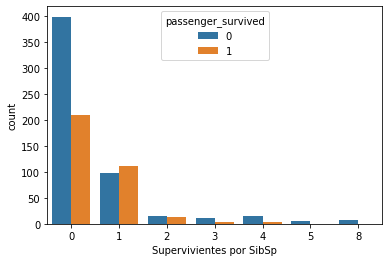

In [336]:
sns.countplot(x = 'SibSp', hue = 'passenger_survived', data=data)
plt.xlabel('Supervivientes por SibSp')

Text(0.5, 0, 'Supervivientes por Parch')

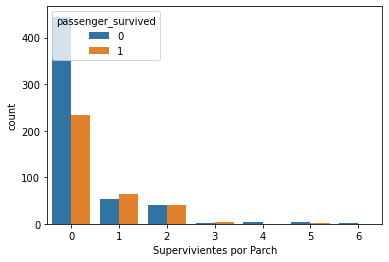

In [337]:
sns.countplot(x = 'Parch', hue = 'passenger_survived', data=data)
plt.xlabel('Supervivientes por Parch')

Observamos que hay mayor supervivencia de las personas que tenían 0 hermanos/esposo/esposa/hijos. Por lo tanto podríamos generar una nueva variable que indique si el pasajero estaba solo o no. 

In [338]:
data['No_family'] = np.where(np.logical_and(data['Parch'] == 0, data['SibSp'] == 0),1,0)
data.head()

,Age,SibSp,Parch,Fare,passenger_sex,passenger_survived,Adult,C,Q,S,Lower,Middle,Upper,No_family
0,22.0,1,0,7.2500,0,0,1,0,0,1,1,0,0,0
1,38.0,1,0,71.2833,1,1,1,1,0,0,0,0,1,0
2,26.0,0,0,7.9250,1,1,1,0,0,1,1,0,0,1
3,35.0,1,0,53.1000,1,1,1,0,0,1,0,0,1,0
4,35.0,0,0,8.0500,0,0,1,0,0,1,1,0,0,1


**Resumen de Feature Enginerring**
* Se imputó la mediana en 'Age' y la moda en 'Embarked'.
* Se removieron las columnas inncesarias: 'PassengerId', 'Name', 'Cabin', 'Ticket'.
* Se creó una nueva columna 'Adult' para indicar si el pasajero era adulto o niño (menor o igual a 15 años).
* 'Embarked' y 'passenger_class' se codificaron con OHE.
* Las variables 'passenger_sex'  y 'passenger_survived' se codificaron a valores 0 y 1. Con (M = 0, F = 1) y (Y = 1, N = 0) respectivamente.
* Se creó una nueva columna 'Alone' para indicar si el pasajero estaba solo o no (SibSP y Parch iguales a cero).

## Entrenamiento, validación y selección

**Separación de datos**

Separamos los datos entre train y test, posteriormente tomamos una porción de los datos de entrenamiento para generar el set de validación: 

In [339]:
Y = data['passenger_survived'].to_frame()
X = data.loc[:,data.columns != 'passenger_survived']

In [340]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size=0.8, random_state=2021)

In [341]:
X_train, X_val, Y_train, Y_val = model_selection.train_test_split(X_train, Y_train, train_size=0.9, random_state=2021)

In [342]:
print("Sets de entrenamiento----------")
print("X_train Shape: ",X_train.shape)
print("Y_train Shape: ",Y_train.shape)
print("Sets de pruebas----------------")
print("X_test Shape: ",X_test.shape)
print("Y_test Shape: ",Y_test.shape)
print("Sets de validación-------------")
print("X_val Shape: ",X_val.shape)
print("Y_val Shape: ",Y_val.shape)

Sets de entrenamiento----------
X_train Shape:  (640, 13)
Y_train Shape:  (640, 1)
Sets de pruebas----------------
X_test Shape:  (179, 13)
Y_test Shape:  (179, 1)
Sets de validación-------------
X_val Shape:  (72, 13)
Y_val Shape:  (72, 1)


Creamos un dataframe vacío para almacenar los resultados de cada experimento luego de entrenar los modelos:

In [642]:
bitacora = pd.DataFrame(columns = ['modelo','config_string','accuracy','f1_score','recall','precision','mse'])
bitacora

,modelo,config_string,accuracy,f1_score,recall,precision,mse


### Árbol de decisión

In [799]:
def tree_model(criterio,splitter, maxDepth, maxFeatures, maxLeafNodes):
    #crear objeto
    modelo_arbol = tree.DecisionTreeClassifier(criterion=criterio,
                                               splitter=splitter,
                                               max_depth=maxDepth,
                                               max_features = maxFeatures, 
                                               max_leaf_nodes = maxLeafNodes) 
    #entrenar el modelo
    modelo_arbol = modelo_arbol.fit(X_train, Y_train) 

    #predecir sobre los datos de validación
    Y_hat = modelo_arbol.predict(X_val)

    #metricas de evaluación
    accuracy = metrics.accuracy_score(Y_val, Y_hat) 
    f1_score = metrics.f1_score(Y_val, Y_hat) 
    recall = metrics.recall_score(Y_val, Y_hat) 
    precision = metrics.precision_score(Y_val, Y_hat)
    mse = metrics.mean_squared_error(Y_val, Y_hat)

    #cadena de configuración
    config_string = "criterion="+str(criterio)+"_MaxDepth="+str(maxDepth)+"_MaxFeatures="+str(maxFeatures)+"_MaxLeafNodes="+str(maxLeafNodes)
    
    resultado = {'modelo':modelo_arbol, 
                 'config_string':config_string, 
                 'accuracy':accuracy, 
                 'f1_score':f1_score, 
                 'recall':recall, 
                 'precision':precision,
                 'mse':mse}
    return resultado

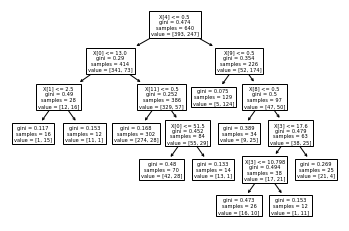

In [1061]:
tree.plot_tree(DecisionTree) 
plt.show()

In [1053]:
import graphviz 
dot_data = tree.export_graphviz(DecisionTree, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("DecisionTree") 

'DecisionTree.pdf'

Realizamos varios experimentos y los añadimos a la bitácora:

In [892]:
bitacora = bitacora.append(tree_model("gini","best",2000,,10), ignore_index = True)
bitacora

,modelo,config_string,accuracy,f1_score,recall,precision,mse
0,DecisionTreeClassifier(criterion='entropy'),criterion=entropy_MaxDepth=None_MaxFeatures=No...,0.805556,0.681818,0.625000,0.750000,0.194444
1,DecisionTreeClassifier(),criterion=gini_MaxDepth=None_MaxFeatures=None_...,0.791667,0.680851,0.666667,0.695652,0.208333
2,"DecisionTreeClassifier(criterion='entropy', ma...",criterion=entropy_MaxDepth=50_MaxFeatures=None...,0.833333,0.739130,0.708333,0.772727,0.166667
3,DecisionTreeClassifier(max_depth=50),criterion=gini_MaxDepth=50_MaxFeatures=None_Ma...,0.833333,0.750000,0.750000,0.750000,0.166667
4,"DecisionTreeClassifier(max_depth=50, max_leaf_...",criterion=gini_MaxDepth=50_MaxFeatures=None_Ma...,0.861111,0.791667,0.791667,0.791667,0.138889
...,...,...,...,...,...,...,...
126,"DecisionTreeClassifier(max_depth=2000, max_fea...",criterion=gini_MaxDepth=2000_MaxFeatures=6_Max...,0.833333,0.700000,0.583333,0.875000,0.166667
127,"DecisionTreeClassifier(max_depth=2000, max_fea...",criterion=gini_MaxDepth=2000_MaxFeatures=5_Max...,0.861111,0.791667,0.791667,0.791667,0.138889
128,"DecisionTreeClassifier(max_depth=2000, max_fea...",criterion=gini_MaxDepth=2000_MaxFeatures=4_Max...,0.805556,0.708333,0.708333,0.708333,0.194444
129,"DecisionTreeClassifier(max_depth=2000, max_fea...",criterion=gini_MaxDepth=2000_MaxFeatures=3_Max...,0.861111,0.791667,0.791667,0.791667,0.138889


In [899]:
bitacora.loc[122][1]

'criterion=gini_MaxDepth=2000_MaxFeatures=10_MaxLeafNodes=10'

### Support Vector Machine (SVM)

In [826]:
def svm_model(C, kernel, shrinking,tol,break_ties):
    #crear objeto y entrenar el modelo
    modelo_svm = svm.SVC(C = C, kernel = kernel, shrinking = shrinking,tol=tol,break_ties=break_ties)
    modelo_svm.fit(X_train, Y_train.values.ravel())

    #predecir sobre los datos de validación
    Y_hat = modelo_svm.predict(X_val)

    #metricas de evaluación
    accuracy = metrics.accuracy_score(Y_val, Y_hat) 
    f1_score = metrics.f1_score(Y_val, Y_hat) 
    recall = metrics.recall_score(Y_val, Y_hat) 
    precision = metrics.precision_score(Y_val, Y_hat)
    mse = metrics.mean_squared_error(Y_val, Y_hat)

    #cadena de configuración
    config_string = "C="+str(C)+"_kernel="+str(kernel)+"_shrinking="+str(shrinking)+"_tol="+str(tol)+"_break_ties"+str(break_ties)
    
    resultado = {'modelo':modelo_svm, 
                 'config_string':config_string, 
                 'accuracy':accuracy, 
                 'f1_score':f1_score, 
                 'recall':recall, 
                 'precision':precision,
                 'mse':mse}
    
    return resultado

Realizamos varios experimentos y los añadimos a la bitácora:

In [827]:
bitacora = bitacora.append(svm_model(1.0, 'linear',False,0.00001,True), ignore_index = True)
bitacora

,modelo,config_string,accuracy,f1_score,recall,precision,mse
0,DecisionTreeClassifier(criterion='entropy'),criterion=entropy_MaxDepth=None_MaxFeatures=No...,0.805556,0.681818,0.625000,0.750000,0.194444
1,DecisionTreeClassifier(),criterion=gini_MaxDepth=None_MaxFeatures=None_...,0.791667,0.680851,0.666667,0.695652,0.208333
2,"DecisionTreeClassifier(criterion='entropy', ma...",criterion=entropy_MaxDepth=50_MaxFeatures=None...,0.833333,0.739130,0.708333,0.772727,0.166667
3,DecisionTreeClassifier(max_depth=50),criterion=gini_MaxDepth=50_MaxFeatures=None_Ma...,0.833333,0.750000,0.750000,0.750000,0.166667
4,"DecisionTreeClassifier(max_depth=50, max_leaf_...",criterion=gini_MaxDepth=50_MaxFeatures=None_Ma...,0.861111,0.791667,0.791667,0.791667,0.138889
...,...,...,...,...,...,...,...
71,"DecisionTreeClassifier(max_depth=50, max_leaf_...",criterion=gini_MaxDepth=50_MaxFeatures=None_Ma...,0.833333,0.769231,0.833333,0.714286,0.166667
72,"DecisionTreeClassifier(max_depth=50, max_leaf_...",criterion=gini_MaxDepth=50_MaxFeatures=None_Ma...,0.791667,0.693878,0.708333,0.680000,0.208333
73,"DecisionTreeClassifier(max_depth=50, max_leaf_...",criterion=gini_MaxDepth=50_MaxFeatures=None_Ma...,0.861111,0.791667,0.791667,0.791667,0.138889
74,"SVC(break_ties=True, kernel='linear', shrinkin...",C=1.0_kernel=linear_shrinking=False_tol=1e-05,0.833333,0.769231,0.833333,0.714286,0.166667


In [829]:
bitacora.loc[8]

modelo           SVC(kernel='linear')
config_string     C=1.0_kernel=linear
accuracy                     0.833333
f1_score                     0.769231
recall                       0.833333
precision                    0.714286
mse                          0.166667
Name: 8, dtype: object

### Naive Bayes

Para Naive Bayes necesitamos primero unificar las variables X y Y en un solo dataset:

In [358]:
dataset_train = pd.merge(X_train, Y_train, left_index = True, right_index = True)
dataset_train = np.array(dataset_train)

dataset_val = pd.merge(X_val, Y_val, left_index = True, right_index = True)
dataset_val = np.array(dataset_val)

In [359]:
# Creamos una función que separa los datos por clase ('passenger_survived') y los guarda en un diccionario:
def separar_por_clase(dataset):
    separated = {}
    for i in range(len(dataset)):
        vector = dataset[i]
        class_value = vector[-1]
        if (class_value not in separated):
            separated[class_value] = list()
        separated[class_value].append(vector)
    return separated

In [360]:
# Calcular la media de una lista de números
def mean(numbers):
    return sum(numbers)/float(len(numbers))
 
# Calcular la desviación estándar de una list de números
def stdev(numbers):
    avg = mean(numbers)
    variance = sum([(x-avg)**2 for x in numbers]) / float(len(numbers)-1)
    return sqrt(variance)
 
# Calcular la media, desviación y conteo para cada columna en el data set
def summarize_dataset(dataset):
    summaries = [(mean(column), stdev(column), len(column)) for column in zip(*dataset)]
    del(summaries[-1])
    return summaries

In [361]:
# Calcular media, desviación y conteo por cada columna agrupáda por clase
def summarize_by_class(dataset):
    separated = separar_por_clase(dataset)
    summaries = dict()
    for class_value, rows in separated.items():
        summaries[class_value] = summarize_dataset(rows)
    return summaries

In [372]:
# Calcular la distribución de probabilidad Gaussiana para x
def calculate_probability(x, mean, stdev):
    exponent = exp(-((x-mean)**2 / (2 * stdev**2 )))
    return (1 / (sqrt(2 * pi) * stdev)) * exponent

In [363]:
# Calcular las probabilidades de cada clase según una fila dada
def calculate_class_probabilities(summaries, row):
    total_rows = sum([summaries[label][0][2] for label in summaries])
    probabilities = dict()
    for class_value, class_summaries in summaries.items():
        probabilities[class_value] = summaries[class_value][0][2]/float(total_rows)
        for i in range(len(class_summaries)):
            mean, stdev, count = class_summaries[i]
            probabilities[class_value] *= calculate_probability(row[i], mean, stdev)
    return probabilities

In [375]:
# Si ejecutamos un ejemplo nos da las probabilidades para cada clase:
summaries = summarize_by_class(dataset_train)
summaries

{1.0: [(28.161943319838056, 13.737418170703485, 247),
  (0.5141700404858299, 0.73168811622438, 247),
  (0.4979757085020243, 0.7956921307184058, 247),
  (50.43901943319837, 62.93807515993663, 247),
  (0.7044534412955465, 0.457214530487074, 247),
  (0.8502024291497976, 0.357597504348151, 247),
  (0.27530364372469635, 0.44757409445511814, 247),
  (0.06882591093117409, 0.2536718922533412, 247),
  (0.6558704453441295, 0.4760482137835933, 247),
  (0.32793522267206476, 0.47041430867172795, 247),
  (0.24696356275303644, 0.4321209870480921, 247),
  (0.4251012145748988, 0.49536211797567686, 247),
  (0.44534412955465585, 0.4980129040879982, 247)],
 0.0: [(29.950381679389313, 12.218804765809528, 393),
  (0.5648854961832062, 1.3020739146463114, 393),
  (0.3231552162849873, 0.7985306779977741, 393),
  (22.598906106870228, 34.06358545485886, 393),
  (0.13231552162849872, 0.33926538614033896, 393),
  (0.9414758269720102, 0.23503117476869603, 393),
  (0.13740458015267176, 0.3447128081185982, 393),
  (0

In [376]:
# ejemplo
probabilities = calculate_class_probabilities(summaries, dataset_train[0])
print(probabilities)

{1.0: 4.8219731658846846e-14, 0.0: 1.5298316275326373e-14}


In [377]:
# Predict the class for a given row
def predict(summaries, row):
    probabilities = calculate_class_probabilities(summaries, row)
    best_label, best_prob = None, -1
    for class_value, probability in probabilities.items():
        if best_label is None or probability > best_prob:
            best_prob = probability
            best_label = class_value
    return best_label

In [378]:
# Funcion para predecir:
def naive_bayes(train, test):
    summarize = summarize_by_class(train)
    predictions = list()
    for row in test:
        output = predict(summarize, row)
        predictions.append(output)      
    return(predictions)

In [558]:
# función para predecir y evaluar el modelo
def naive_bayes_model(train, test, Y_test):
    Y_hat = naive_bayes(train, test)

    #metricas de evaluación
    accuracy = metrics.accuracy_score(Y_test, Y_hat) 
    f1_score = metrics.f1_score(Y_test, Y_hat) 
    recall = metrics.recall_score(Y_test, Y_hat) 
    precision = metrics.precision_score(Y_test, Y_hat)
    mse = metrics.mean_squared_error(Y_val, Y_hat)
    
    config_string = "pdf=gaussian"
    
    resultado = {'modelo':naive_bayes, 
                 'config_string':config_string, 
                 'accuracy':accuracy, 
                 'f1_score':f1_score, 
                 'recall':recall, 
                 'precision':precision,
                 'mse':mse}
    
    return resultado

In [656]:
bitacora = bitacora.append(naive_bayes_model(dataset_train, dataset_val, Y_val), ignore_index = True)
bitacora

,modelo,config_string,accuracy,f1_score,recall,precision,mse
0,DecisionTreeClassifier(criterion='entropy'),criterion=entropy_MaxDepth=None_MaxFeatures=No...,0.805556,0.681818,0.625000,0.750000,0.194444
1,DecisionTreeClassifier(),criterion=gini_MaxDepth=None_MaxFeatures=None_...,0.791667,0.680851,0.666667,0.695652,0.208333
2,"DecisionTreeClassifier(criterion='entropy', ma...",criterion=entropy_MaxDepth=50_MaxFeatures=None...,0.833333,0.739130,0.708333,0.772727,0.166667
3,DecisionTreeClassifier(max_depth=50),criterion=gini_MaxDepth=50_MaxFeatures=None_Ma...,0.833333,0.750000,0.750000,0.750000,0.166667
4,"DecisionTreeClassifier(max_depth=50, max_leaf_...",criterion=gini_MaxDepth=50_MaxFeatures=None_Ma...,0.861111,0.791667,0.791667,0.791667,0.138889
5,"DecisionTreeClassifier(criterion='entropy', ma...",criterion=entropy_MaxDepth=50_MaxFeatures=None...,0.861111,0.791667,0.791667,0.791667,0.138889
6,"DecisionTreeClassifier(criterion='entropy', ma...",criterion=entropy_MaxDepth=50_MaxFeatures=None...,0.833333,0.769231,0.833333,0.714286,0.166667
7,SVC(),C=1.0_kernel=rbf,0.736111,0.457143,0.333333,0.727273,0.263889
8,SVC(kernel='linear'),C=1.0_kernel=linear,0.833333,0.769231,0.833333,0.714286,0.166667
9,"SVC(C=0.5, kernel='linear')",C=0.5_kernel=linear,0.805556,0.720000,0.750000,0.692308,0.194444


### Regresión Logística

El modelo de regresión logística lo definimos en TensorFlow por lo que primero requerimos definir el grafo:

In [609]:
tf.reset_default_graph()
grafo = tf.Graph()
with grafo.as_default():
    
    # tensores de entrada
    tensor_x = tf.placeholder(shape=[None, 13], dtype = tf.float32, name = "Features")
    tensor_y = tf.placeholder(shape=[None, 1], dtype = tf.float32, name = "Passenger_Survived")
    
    # tensores de parámetros
    weight = tf.get_variable("peso",dtype=tf.float32,shape=[13,1],initializer=tf.zeros_initializer())
    bias = tf.get_variable("sesgo",dtype=tf.float32,shape=[1],initializer=tf.zeros_initializer())
    
    with tf.name_scope("Hiper_Parametros"):
        # hiper-parámetros
        learning_rate = tf.placeholder("float", name = "Learning_Rate")
        epochs = tf.placeholder(tf.int32, name = "Epochs")
        batch_size = tf.placeholder(tf.int32, name = "Batch_Size")
        lam = tf.placeholder("float", name = "Lambda")

    with tf.name_scope("Hipotesis"):
        # modelo lineal
        z = tf.add(tf.matmul(tensor_x, weight), bias)
        # prediccion
        Y_hat = tf.math.sigmoid(z)
    
    with tf.name_scope("Costo"):
        # función de costo
        regL1 = lam * tf.reduce_sum(tf.math.abs(weight))
        costo = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = z, labels = tensor_y)) + regL1
        costo_summary = tf.summary.scalar("entropy", costo)
    
    with tf.name_scope("Gradient_Descent_Update"):
        # gradient descent
        gradiente = tf.gradients(costo, [weight, bias])
        actualizacion_weight = tf.assign(weight, weight - learning_rate*gradiente[0])
        actualizacion_bias = tf.assign(bias, bias - learning_rate*gradiente[1])
        actualizacion_parametros = tf.group(actualizacion_weight,actualizacion_bias)
        
    with tf.name_scope("Metricas_evaluacion"):
        # Acuracy del modelo manual
        """ #manual:
        correcto = tf.equal(tf.argmax(z,1), tf.argmax(tensor_y,1))
        accuracy = tf.reduce_mean(tf.cast(correcto, tf.float32))
        accuracy_summary = tf.summary.scalar('Accuracy', accuracy)
        """
        acc, acc_op = tf.metrics.accuracy(labels=tensor_y, 
                                          predictions=Y_hat)
        accuracy_summary = tf.summary.scalar('Accuracy', acc)
        
        # Recall
        recall, recall_op = tf.metrics.recall(labels=tf.argmax(tensor_y, 1),
                                              predictions=tf.argmax(Y_hat,1))
        recall_summary = tf.summary.scalar('Recall', recall)
        
        # Precision
        precision, precision_op = tf.metrics.precision(labels=tf.argmax(tensor_y, 1),
                                                      predictions=tf.argmax(Y_hat,1))
        precision_summary = tf.summary.scalar('Precision', precision)
    
        # Error
        mse, mse_op = tf.metrics.mean_squared_error(labels=tf.argmax(tensor_y, 1),
                                            predictions=tf.argmax(Y_hat,1))
        mse_summary = tf.summary.scalar('MSE', mse)
        
        # F1-Score
        f1_score = tf.math.multiply(2.0,tf.divide(
            tf.math.multiply(precision_op, recall_op),
            tf.add(precision_op, recall_op)))

        f1_score_summary = tf.summary.scalar('f1-Score', f1_score)
    
    summaries = tf.summary.merge_all()
    
    init = tf.global_variables_initializer()
    init2 = tf.local_variables_initializer()

Grafo en TensorBoard:
<img src="https://github.com/eddson90/tareas_data_science/blob/main/Grafo_ProyectoFinal_SL1_RegLog.PNG?raw=true" alt="alt text" width="800"/>

**Ahora creamos la función de entrenamiento:**

In [612]:
def reg_log_train(X_train, Y_train, lr, epoch, b_size, reg_param):
    tf.reset_default_graph()
    total_iteraciones = int(len(X_train)/b_size)
    
    with tf.Session(graph = grafo) as sess:
        timestamp = time.strftime('%Y%m%d_%H%M%S', time.localtime(time.time()))
        writer = tf.summary.FileWriter('./TB_log_dir/proyecto_final/'
                                       +str(timestamp)
                                       +'_lr='+str(lr)
                                       +'_b_size='+str(b_size)
                                       +'_epoch='+str(epoch),grafo)
        sess.run(init)
        sess.run(init2)
    
        for e in range(epoch):
            for i in range(total_iteraciones):
                muestra_inicio = i*b_size
                muestra_fin = muestra_inicio + b_size
                x_mb = X_train[muestra_inicio:muestra_fin]
                y_mb = Y_train[muestra_inicio:muestra_fin]
                
                feed_dict = {tensor_x:x_mb, tensor_y:y_mb, learning_rate:lr, epochs:epoch, batch_size:b_size, lam:reg_param}
                act_p, w, b, summ = sess.run([actualizacion_parametros, weight, bias, summaries], feed_dict = feed_dict)
                writer.add_summary(summ, e)
                
            feed_dict = {tensor_x:X_train, tensor_y:Y_train}
            prediccion = sess.run(Y_hat, feed_dict = feed_dict)
            
        final_weight, final_bias = sess.run([weight, bias], feed_dict = feed_dict)
        
        writer.close()
        
    return lr, b_size, reg_param, final_weight, final_bias

Monitoreo de métricas en Tensorboard:
<img src="https://github.com/eddson90/tareas_data_science/blob/main/cross_entropy_SL1_proyecto_final.PNG?raw=true" alt="alt text" width="400"/>

Métricas de performance:
<img src="https://github.com/eddson90/tareas_data_science/blob/main/metricas_sl1_proyecto_final_tf.PNG?raw=true" alt="alt text" width="600"/>

In [933]:
X_train_norm=(X_train-X_train.mean())/X_train.std()
Y_train_norm = (Y_train-Y_train.mean())/Y_train.std()

X_val_norm=(X_val-X_val.mean())/X_val.std()
Y_val_norm = (Y_val-Y_val.mean())/Y_val.std()

In [953]:
lr, b_size, reg_param, w, b = reg_log_train(X_train, Y_train, 0.001, 2000, 128, 0.001)

In [625]:
def regLog_predict(X_test, frontera):
    z = np.matmul(np.array(X_test),w) + b
    Y_hat = 1/(1 + np.exp(-z))
    Y_hat[Y_hat<frontera]=0
    Y_hat[Y_hat>=frontera]=1
    Y_hat = pd.DataFrame(Y_hat)
  
    return Y_hat

def reg_log_model(X_test, Y_test, frontera):
    
    Y_hat = regLog_predict(X_test, frontera)
    
    accuracy = metrics.accuracy_score(Y_test, Y_hat) 
    f1_score = metrics.f1_score(Y_test, Y_hat) 
    recall = metrics.recall_score(Y_test, Y_hat) 
    precision = metrics.precision_score(Y_test, Y_hat)
    mse = metrics.mean_squared_error(Y_val, Y_hat)
    
    config_string = "lr="+str(lr)+"_batchsize="+str(b_size)+"_lambda="+str(reg_param)+"_frontera="+str(frontera)
    
    resultado = {'modelo':regLog_predict, 
                 'config_string':config_string, 
                 'accuracy':accuracy, 
                 'f1_score':f1_score, 
                 'recall':recall, 
                 'precision':precision,
                 'mse':mse}
    
    return resultado

In [961]:
bitacora = bitacora.append(reg_log_model(X_val,Y_val,0.47), ignore_index = True)
bitacora

,modelo,config_string,accuracy,f1_score,recall,precision,mse
0,DecisionTreeClassifier(criterion='entropy'),criterion=entropy_MaxDepth=None_MaxFeatures=No...,0.805556,0.681818,0.625000,0.750000,0.194444
1,DecisionTreeClassifier(),criterion=gini_MaxDepth=None_MaxFeatures=None_...,0.791667,0.680851,0.666667,0.695652,0.208333
2,"DecisionTreeClassifier(criterion='entropy', ma...",criterion=entropy_MaxDepth=50_MaxFeatures=None...,0.833333,0.739130,0.708333,0.772727,0.166667
3,DecisionTreeClassifier(max_depth=50),criterion=gini_MaxDepth=50_MaxFeatures=None_Ma...,0.833333,0.750000,0.750000,0.750000,0.166667
4,"DecisionTreeClassifier(max_depth=50, max_leaf_...",criterion=gini_MaxDepth=50_MaxFeatures=None_Ma...,0.861111,0.791667,0.791667,0.791667,0.138889
...,...,...,...,...,...,...,...
152,<function regLog_predict at 0x000001B0FDFADC10>,lr=0.001_batchsize=128_lambda=0.001_frontera=0.7,0.694444,0.214286,0.125000,0.750000,0.305556
153,<function regLog_predict at 0x000001B0FDFADC10>,lr=0.001_batchsize=128_lambda=0.001_frontera=0.3,0.777778,0.733333,0.916667,0.611111,0.222222
154,<function regLog_predict at 0x000001B0FDFADC10>,lr=0.001_batchsize=128_lambda=0.001_frontera=0.2,0.430556,0.539326,1.000000,0.369231,0.569444
155,<function regLog_predict at 0x000001B0FDFADC10>,lr=0.001_batchsize=128_lambda=0.001_frontera=0.45,0.847222,0.765957,0.750000,0.782609,0.152778


In [832]:
bitacora.loc[54]

modelo           <function regLog_predict at 0x000001B0FDFADC10>
config_string    lr=0.001_batchsize=8_lambda=0.001_frontera=0.68
accuracy                                                0.833333
f1_score                                                     0.7
recall                                                  0.583333
precision                                                  0.875
mse                                                     0.166667
Name: 54, dtype: object

In [1005]:
#Exportar todos los experimentos a un csv
bitacora.to_csv(r'C:\Users\eddso\OneDrive\Maestría\Tareas Git Hub\tareas_data_science\bitacora.csv')
bitacora.to_csv(r'C:\Users\eddso\OneDrive\Maestría\Tareas Git Hub\tareas_data_science\bitacora.tsv', sep='\t')

In [1023]:
dataset_train[0]

array([38.    ,  1.    ,  5.    , 31.3875,  1.    ,  1.    ,  0.    ,
        0.    ,  1.    ,  1.    ,  0.    ,  0.    ,  0.    ,  1.    ])

### Selección de los mejores modelos

Los mejores modelos de cada tipo de algoritmo corresponden a las filas 121 (árbol de decisión), 8 (SVM), 13 (Naive Bayes) y 156 (regresión logística). 

In [982]:
DecisionTree = bitacora.loc[121][0]
SVM = bitacora.loc[8][0]
NaiveBayes = bitacora.loc[13][0]
RegLog = bitacora.loc[156][0]

### Prueba/Evaluación Final

Dado el conjunto de observaciones X del conjunto de pruebas y los 4 modelos elegidos, predecimos sobre estas observaciones con cada modelo. 

In [983]:
predictionTree = DecisionTree.predict(X_test).reshape(-1,1)

In [707]:
predictionSVM = SVM.predict(X_test).reshape(-1,1)

In [692]:
# Para Naive Bayes recordemos que necesitamos el dataset "consolidado"
dataset_test = pd.merge(X_test, X_test, left_index = True, right_index = True)
dataset_test = np.array(dataset_test)

In [708]:
predictionNB = np.array(NaiveBayes(dataset_train, dataset_test)).reshape(-1,1)

In [984]:
predictionRegLog = np.array(RegLog(X_test, 0.68))

In [985]:
predicciones = np.hstack((predictionTree, predictionSVM, predictionNB, predictionRegLog))

In [986]:
tabla_predicciones = pd.DataFrame(predicciones)
tabla_predicciones.columns = ['DecisionTree', 'SVM','NaiveBayes','RegLog']
tabla_predicciones.head()

,DecisionTree,SVM,NaiveBayes,RegLog
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0
4,0.0,1.0,1.0,0.0


A continuación, combinamos los resultados de las predicciones en una predicción final (moda de resultados individuales).

In [987]:
prediccion_final, conteo = stats.mode(predicciones, axis = 1)
prediccion_final = pd.DataFrame(prediccion_final)
prediccion_final

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
174,0.0
175,1.0
176,1.0
177,0.0


Ahora, calculamos las métricas de evaluación del modelo final:

In [755]:
def metricas(prediccion_final, Y_test):
    accuracy = metrics.accuracy_score(Y_test, prediccion_final) 
    f1_score = metrics.f1_score(Y_test, prediccion_final) 
    recall = metrics.recall_score(Y_test,prediccion_final) 
    precision = metrics.precision_score(Y_test, prediccion_final)
    mse = metrics.mean_squared_error(Y_test, prediccion_final)
    
    resultado = {'modelo':'modelo_combinado',  
                 'accuracy':accuracy, 
                 'f1_score':f1_score, 
                 'recall':recall, 
                 'precision':precision,
                 'mse':mse}
    
    return resultado

Creamos un data frame para mostrar el resultado final:

In [988]:
resultado_final = pd.DataFrame(columns = ['modelo','accuracy','f1_score','recall','precision','mse'])
resultado_final.append(metricas(prediccion_final, Y_test), ignore_index = True)

,modelo,accuracy,f1_score,recall,precision,mse
0,modelo_combinado,0.748603,0.587156,0.450704,0.842105,0.251397


### Conclusiones

* Se ejecutaron 156 experimentos con los 4 modelos y una gran variedad de configuraciones, de los cuales se seleccionaron como los mejores modelos de cada tipo los siguientes: 
    
    + Modelo de árbol de decisión, con impuridad de Gini, features máximas igual a 11 y con máximo de nodos de hoja de 10. 
    + Modelo Support Vector Machine con C igual a 1.0 y kernel lineal. 
    + Modelo de Naive Bayes con distribución Gaussiana. 
    + Modelo de Regresión Logística con learning_rate de 0.001, mini-batch igual a 128, lambda (parámetro de regularización L1) igual 0.001 y frontera de decisión igual 0.47. 
    
    
* Los modelos de árbol de decisión, SVM, Naive Bayes y Regresión logística generaron accuracy de 0.875, 0.833, 0.847, 0.861 respectivamente, en el dataset de evaluación. 


* El modelo combinado (basado en la moda de los resultados individuales de los mejores modelos) generó un accuracy de 0.7486 en el dataset de pruebas, esto a pesar de que los modelos por individual superaban el accuracy mínimo deseado de 80%. 


* Se realizaron pruebas de normalización de datos para el algoritmo de regresión logística sin obtener mejores resultados que los ya mostrados. 


* En la sección de feature engineering, se imputó la mediana en 'Age', la moda en 'Embarked', se removieron 'PassengerId', 'Name', 'Cabin', 'Ticket'. Se creó una columna 'Adult' para indicar si los pasajeros eran menores o iguales a 15 años y una columna 'No_family' para indicar si el pasajero viajaba acompañado o no. También se transformaron las variables 'Embarked' y 'passenger_class' con One Hot Encoding. 


* La columna 'cabin' a pesar de tener información importante porque la ubicación de las cabinas en el Titanic era un predictor importante sobre si un pasajero sobrevivía o no, no estaba completa y esa falta de información afectó drásticamente el desempeño de los modelos. 

### Recomendaciones

* Es de gran utilidad crear una bitácora de experimentos en la que se van registrando las diferentes pruebas en las evaluaciones de modelos, una mejora que podría realizarse es añadir una columna de 'categoría' indicando la categoría de los modelos evaluados de manera que sea más simple buscar los mejores modelos de cada tipo, esto se vuelve especialmente útil cuando la cantidad de experimentos incrementa. 


* En TensorFlow, al momento de definir un grafo es importante validar que las formas ('shape') de los tensores tengan concordancia matemática en las operaciones que se definan (principalmente si se realizan multiplicaciones matriciales y/o sumas con otros vectores. 


* Es de vital importancia asegurarse de que el dataset esté balanceado antes de dividirlo, de manera que los resultados del entrenamiento y  las evaluaciones se acercen más a los resultados que los modelos podrían obtener en un ambiente de prueba reales.

### Comentarios adicionales

* Uno de los mayores obstáculos en la creación de algunos de los modelos fue la poca experiencia práctica en su implementación. Creo que tener un laboratorio de la clase aportaría mucho valor a las clases teóricas que también son fundamentales para la creación de algoritmos en cualquier herramienta. 


* Al ser la primera clase de Statistical Learning, es fascinante el alcance y las capacidades adquiridas, ya que con un conocimiento básico de regresiones al inicio de clase, se construyen bloques de conocimiento que permiten ir elaborando y exponiendo los modelos más complejos. 